Домашняя работа №2: Крестики-нолики
выполнил: Денисов Артем, MADE-ML-32

In [1]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]'

In [68]:
import gym

import matplotlib.pyplot as plt
import math
import random
import numpy as np
import scipy as sp
import pickle

from collections import namedtuple, defaultdict
from itertools import count

from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## Реализуем крестики-нолики

Перенес окружение в отдельный файл

In [76]:
from TicTacToe import TicTacToe, plot_test_game

#### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [77]:
def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]

def not_avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array != '1')[0]

def play_game(env, Q, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(s))
        else:
            action = np.argmax(Q[s])
        action_tuple = env.action_from_int(action)
        (s, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        if print_board:
            env.printBoard()
        player = player * -1
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

def evaluate(env, Q, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    rewards1 = []
    rewards2 = []
    for _ in range(n):
        reward1, reward2 = play_game(
            env, 
            Q, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def get_pi_by_Q(Q):
    pi = {k: np.argmax(v) for k, v in Q.items()}
    return defaultdict(int, pi)

class Agent:
    def __init__(self, alpha, gamma, s=None, a=None):
        self.s = s
        self.a = a
        self.alpha = alpha
        self.gamma = gamma
        
    def update_Q(self, Q, state, action, reward):
        Q[self.s][self.a] = Q[self.s][self.a] + self.alpha * (reward + self.gamma * np.max(Q[state]) - Q[self.s][self.a])
        self.s = state
        self.a = action
        
def Q_learning_episode(env, Q, alpha=0.05, epsilon=0.1, gamma=1):
    env.reset()
    s, empty_spaces, turn = env.getState()    
    agents = (
        Agent(alpha=alpha, gamma=gamma), 
        Agent(alpha=alpha, gamma=gamma)
    )
    done = False
    agent_idx = 0
    
    while not done:
        Q[s][not_avail_actions(s)] = -999
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(avail_actions(s))
        agent = agents[agent_idx]
        agent.update_Q(Q, s, a, 0)
        agent_idx = 1 - agent_idx 
        (s, empty_spaces, turn), r , done, _ = env.step(env.action_from_int(a))    

    if r == -10:
        agent.update_Q(Q, s, a, r)
    else:
        agents[0].update_Q(Q, s, a, r) 
        agents[1].update_Q(Q, s, a, -r) 
        
    return Q

def Q_learning(env, Q, episodes=100000, alpha=0.05, evaluate_every=100, epsilon=0.3, gamma=1):
    hist_p1 = []
    hist_p2 = []
    iters = []

    for i in range(episodes):
        Q = Q_learning_episode(env=env, Q=Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if i % evaluate_every == 0:
            res_p1 = evaluate(env, Q, n=100, disable_tqdm=True, player1_random=False, player2_random=True)[0]
            res_p2 = evaluate(env, Q, n=100, disable_tqdm=True, player1_random=True, player2_random=False)[1]
            hist_p1.append(res_p1)
            hist_p2.append(res_p2)
            iters.append(i)
            
    return Q, hist_p1, hist_p2, iters


In [78]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [79]:
Q, hist_p1, hist_p2, iters = Q_learning(env, Q, episodes=50000, alpha=0.05, epsilon=0.8)

Обучение на достке 3ч3 происходит быстро и достаточно устойчиво к изменению параметров

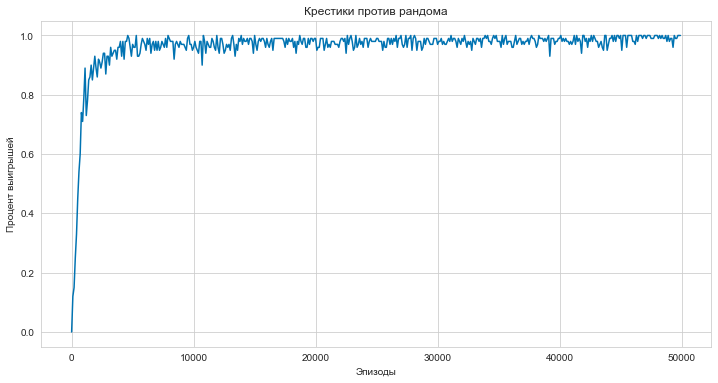

In [23]:
plt.figure(figsize=(12, 6))
plt.title('Крестики против рандома')
plt.xlabel('Эксперименты')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, hist_p1);

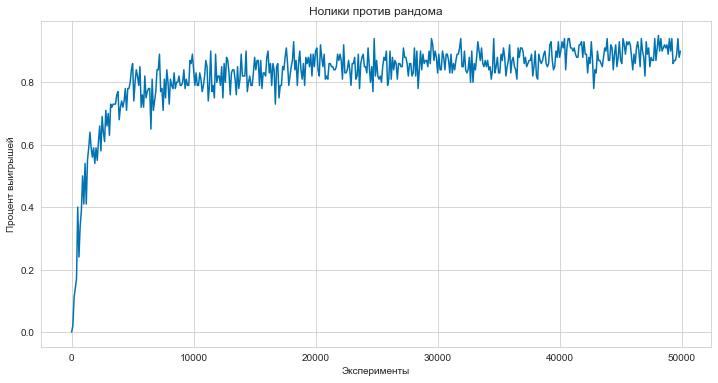

In [24]:
plt.figure(figsize=(12, 6))
plt.title('Нолики против рандома')
plt.xlabel('Эксперименты')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, hist_p2);

#### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

In [29]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [30]:
Q, hist_p1, hist_p2, iters = Q_learning(env, Q, episodes=50000, alpha=0.05, epsilon=0.8)

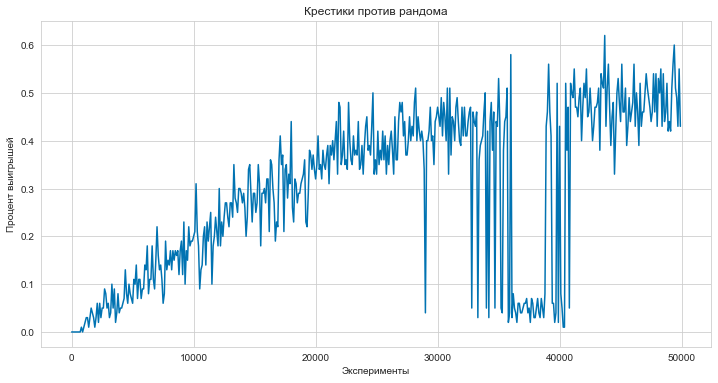

In [31]:
plt.figure(figsize=(12, 6))
plt.title('Крестики против рандома')
plt.xlabel('Эксперименты')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, hist_p1)

In [80]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [81]:
Q, hist_p1, hist_p2, iters = Q_learning(env, Q, episodes=150000, alpha=0.05, epsilon=0.8)

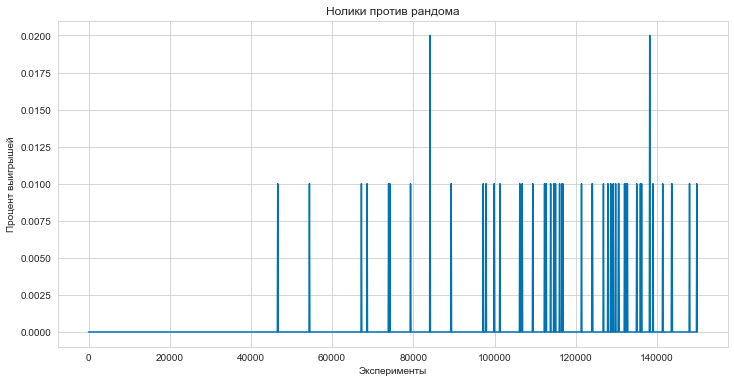

In [82]:
plt.figure(figsize=(12, 6))
plt.title('Нолики против рандома')
plt.xlabel('Эксперименты')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot(iters, hist_p2)

и вправду обучение требует гораздо больше времени. Обучать доски выше 5х5 лушче другими методами. Поле 5x5 при 150 000 экспериментов даже только не начало обучаться

#### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. 

In [57]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class Player:
    def __init__(self, memory_capacity=10000):
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.store((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def new_game(self):
        self.state = None
        self.action = None        

        
def state_to_layers(state):
    return np.array([
        (state == 1).astype(float), 
        (state == -1).astype(float), 
        (state == 0).astype(float)
    ])
        
def get_action_from_model(model, state):
    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()
    return action

def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    
def get_action(model, state, game_hash, epsilon):
    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))
    return action
        
def play_game_model(env, model, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)
        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        player = player * -1
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        
def evaluate_model(env, model, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    model.eval()
    rewards1 = []
    rewards2 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game_model(
            env, 
            model, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def train_batch(model, optimizer, criterion, replay_memory, batch_size=128, gamma=1):
    
    if len(replay_memory) < batch_size:
        return
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


def play_episode(env, model1, model2, epsilon, player1, player2):
    env.reset()
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board.copy()
    done = False
    player1.new_game()
    player2.new_game()
    players = (player1, player2)
    models = (model1, model2)
    player_idx = 0
    
    while not done:
        player = players[player_idx]
        model = models[player_idx]
        action = get_action(model, state, game_hash, epsilon)
        player.add_exp(state, action, 0)
        player_idx = 1 - player_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        state = env.board.copy()
        
    if reward == -10:
        player.add_exp(state, action, reward)
    else:
        players[0].add_exp(state, action, reward)
        players[1].add_exp(state, action, -reward)
        

def run_learning(env, model1_tuple, model2_tuple, criterion, episodes=10000, eps_init=0.5, batch_size=64, gamma=1, model_name='dqn'):
    p1, p2 = Player(), Player()
    model1, optimizer1, scheduler1 = model1_tuple
    model2, optimizer2, scheduler2 = model2_tuple
    
    loss_cache_p1 = []
    loss_cache_p2 = []
    hist_p1 = []
    hist_p2 = []
    iters = []
    loss_hist_p1 = []
    loss_hist_p2 = []
    best_result_p1 = 0
    best_result_p2 = 0
    pbar = tqdm(range(episodes))
    
    eps_final = 0.05
    eps_decay = int(episodes / 2)
    
    for i in pbar:
        eps_threshold = eps_init
        for _ in range(1):
            play_episode(env, model1, model2, eps_threshold, p1, p2)
        
        loss1 = train_batch(model1, optimizer1, criterion, p1.memory, batch_size=batch_size, gamma=gamma)
        loss2 = train_batch(model2, optimizer2, criterion, p2.memory, batch_size=batch_size, gamma=gamma)
        if loss1 is not None:
            loss_cache_p1.append(loss1)
        if loss2 is not None:
            loss_cache_p2.append(loss2)
        
        if (i + 1) % 100 == 0:
            result_p1, _, _ = evaluate_model(env, model1, n=200, player1_random=False, player2_random=True, disable_tqdm=True)
            _, result_p2, _ = evaluate_model(env, model2, n=200, player1_random=True, player2_random=False, disable_tqdm=True)
            
            iters.append(i)
            hist_p1.append(result_p1)
            hist_p2.append(result_p2)
            
            mean_loss_p1 = np.mean(loss_cache_p1) if loss_cache_p1 else 0
            loss_hist_p1.append(mean_loss_p1)
            
            mean_loss_p2 = np.mean(loss_cache_p2) if loss_cache_p2 else 0
            loss_hist_p2.append(mean_loss_p2)
            
            loss_cache_p1 = []
            loss_cache_p2 = []
            
            total_result = result_p1 + result_p2
            if scheduler1 is not None:
                scheduler1.step(mean_loss_p1)
            if scheduler2 is not None:
                scheduler2.step(mean_loss_p2)
            
            pbar.set_postfix({
                'l1': mean_loss_p1, 
                'l2': mean_loss_p2, 
                'p1': result_p1, 
                'p2': result_p2, 
#                 'total': total_result,
                'eps': eps_threshold,
            })

            if best_result_p1 < result_p1:
                torch.save(model1.state_dict(), f'best_{model_name}_p1.pth')
            if best_result_p2 < result_p2:
                torch.save(model2.state_dict(), f'best_{model_name}_p2.pth')
                
    return hist_p1, hist_p2, loss_hist_p1, loss_hist_p2, iters 

In [61]:
class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [70]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [71]:
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [72]:
hist_p1, hist_p2, loss_hist_p1, loss_hist_p2, iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=256,
    gamma=1
)

100%|███████████████████████████| 20000/20000 [21:34<00:00, 15.45it/s, l1=0.0508, l2=0.073, p1=0.93, p2=0.755, eps=0.5]


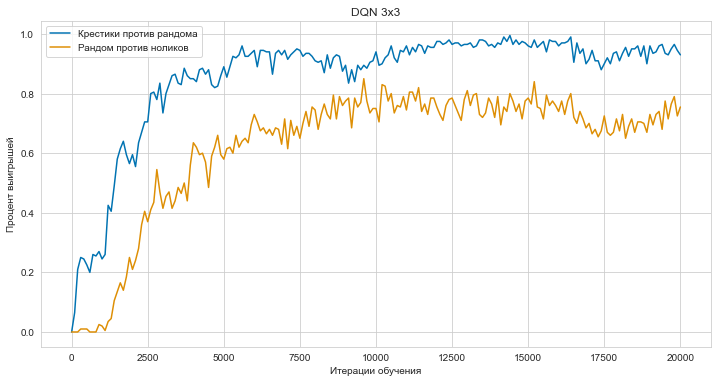

In [73]:
plt.figure(figsize=(12, 6))
plt.title('DQN 3x3')
plt.xlabel('Эксперименты')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против рандома')
plt.plot([0] + iters, [0] + hist_p2, label='Нолики против рандома')
plt.legend();

#### 4. Реализуйте Dueling DQN.

In [96]:
class DuelingDQN_3x3(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
    
        self.V = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
        self.A = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 9),
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        A = self.A(x)
        V = self.V(x)
        Q = V + (A - A.mean(dim=1, keepdim=True).expand(x.size(0), 9))
        return Q

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
LR = 1e-6
WEIGHT_DECAY = 1e-7
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DuelingDQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DuelingDQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [91]:
hist_p1, hist_p2, loss_hist_p1, loss_hist_p2, iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=128,
    model_name='dueling_dqn',
    gamma=0.9
)


100%|█████████████████████████| 20000/20000 [21:48<00:00, 15.28it/s, l1=0.0414, l2=0.0672, p1=0.935, p2=0.695, eps=0.5]


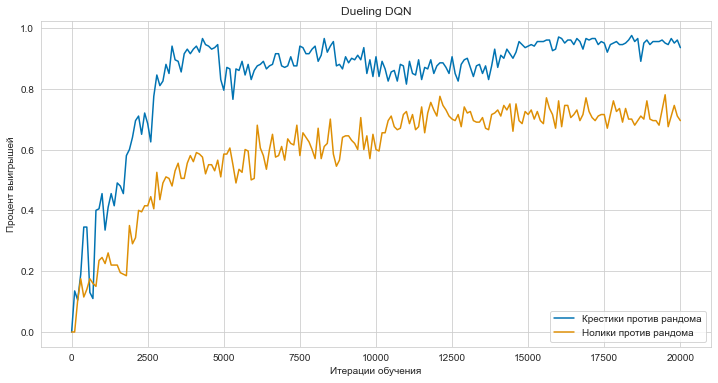

In [92]:
plt.figure(figsize=(12, 6))
plt.title('Dueling DQN')
plt.xlabel('Итерации обучения')
plt.ylabel('Процент выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против рандома')
plt.plot([0] + iters, [0] + hist_p2, label='Нолики против рандома')
plt.legend()